In [169]:
import numpy as np
from scipy.stats import multivariate_normal as mvn, _multivariate
import numpy as np
from typing import List
import matplotlib.pyplot as plt
from sklearn.datasets._samples_generator import make_blobs
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture

# Assigment 5 - Bayesian Classifier and Gaussian Mixture Models

In the 5th assigment of the class we will study the Bayes Classifier.  

We will start with a quick demonstration of Gaussian Mixture Models with sklearn.

You have to implement two different variants of the bayes classifier using the assumption that the conditional probability P(x|y):
   1. Gaussian Bayes Classifier. P(x|y) ~ Gaussian Distribution (Normal)
   2. Gaussian Mixture Bayes Classifier. P(x|y) ~ Gaussian Mixture Model  

# Step 1. Bayesian Classifier with Gaussian Model

We begin with the implementation of the Gaussian Naive Bayes Classifier.

In the naive Bayes Classifier you have to calculate:
1. the prior for each class p(y)
2. the parameters of the gaussian distribution for each class y in order to model p(x|y) according to their empirical values
3. use the bayes theorem to predict the p(y|x) 

After obtain the parameter we can get posterior. The final prediction of our model can be the class with the maximum posterior.

Fill the class below and use it to:   
1. fit your model using .fit() method
2. get the propabilities of each class for the different X using .predict_proba() method
3. make the final predictions using the .predict() method and calculate the accuracy of your model

In [170]:
class GaussianNaiveBayesClassifier:
    """
    Implementation of Naive Bayes Classifier
    """

    def __init__(self):
        # initialization of required variables.
        self.models: List[_multivariate.multivariate_normal_gen] = None # p(x|y)
        self.prior: np.ndarray = None # p(y)
        self.n_classes: int = None
        self.n_features: int = None
        self.means: np.ndarray = None
        self.cov: np.ndarray = None

    def fit(self, X, y) -> None:
        """
        Calculate the parameters of the gaussian models for each class i.e P(x|y), as well as the prior class probabilities P(y).
        :param X: The input features
        :param y: The labels
        :return: None
        """
        self.n_features = X.shape[1]
        self.n_classes = len(set(y))

        # Calculate the prior P(y) for each class
        # fill your code
        _, count_y = np.unique(y, return_counts=True)
        self.prior = count_y / np.sum(count_y)

        self.models = [None] * self.n_classes
        self.means = np.zeros(shape=(self.n_classes, self.n_features))
        self.cov = np.zeros(shape=(self.n_classes, self.n_features, 2))

        for class_y in range(self.n_classes):
            mean = np.mean(X[y == class_y], axis=0)
            cov = np.cov(X[y == class_y], rowvar=False)

            pdf = mvn(mean=mean, cov=cov)

            self.models[class_y] = pdf.pdf(X)
            self.means[class_y, :] = mean
            self.cov[class_y, :, :] = cov

    def predict_proba(self, X) -> np.ndarray:
        """
        Calculate the posterior probability of each class given the features, i.e. P(y|x).
        You can calculate this with Bayes's theorem:
                    P(y|x) = P(x|y) P(y) / P(x).
                    P(y|x): The Posterior probability
                    P(x|y): The Likelihood probability
                    P(y): Prior probability
                    P(x): The evidence \sum_{y'} P(x|y') P(y')
        :param X:
        :return: The posterior probability of each class given the features
        """
        n_examples = X.shape[0]
        posterior = np.zeros([self.n_classes, n_examples])

        # Calculate the posterior P(y|x) for each class
        for y_index in range(self.n_classes):
            p_x_y = self.models[y_index]
            p_y = self.prior[y_index]
            p_x = np.sum(p_x_y * p_y)
            posterior[y_index, :] = p_x_y * p_y / p_x

        return posterior

    def predict(self, X) -> np.ndarray:
        """
        Make predicted class with the maximum posterior P(y|x)
        :param X:
        :return: The predicted class of each example
        """
        prediction = self.predict_proba(X)
        return np.argmax(prediction, axis=0)
    
    def score(self, X, y) -> float:
        """
        Calculate the accuracy of the classifier
        :param X: The input features
        :param y: The labels
        :return: The accuracy of the classifier
        """
        return np.mean(self.predict(X) == y)
    
    def plot(self, X: np.ndarray, predicted: np.ndarray, colors = ["red", "green", "blue", "yellow"], means_colors=None) -> None:
        """
        Plot the decision boundary of the classifier
        :param X: The input features
        :param predicted: The predicted class
        :param colors: The colors of each class
        :param means_colors: The colors of the means of each class
        :return: None
        """
        means_colors = means_colors if means_colors is not None else colors
        predicted_color = [colors[predicted[i]] for i in range(len(predicted))]

        plt.figure()
        plt.scatter(X[:,0], X[:,1], c=predicted_color, alpha=0.1)
        for i in range(self.n_classes):
            plt.scatter(self.means[i,0], self.means[i,1], label=f"mean of class {i}", color=means_colors[i])
        plt.legend()
        plt.show()

# Step 2.  Bayesian Classifier with Gaussian mixture model

Implement the Bayesian Classifier with Gaussian mixture model.
The model is as before, but instead of using the Gaussian Distribution to model the P(x|y) for each class, we use a mixture of Gaussian's.

So you have to find the parameters of a GMM ($w_k$, $m_k$, $cov_k$) for each different y.  
note: To fit the gmm of each class y you can use the sklearn as we demonstrate before

Fill the class below and use it to get:  
1. fit your model using .fit() method
2. the propabilities of each class for the different x using .predict_proba() method
3. make the final predictions using the .predict() method and calculate the accuracy of your model
4. compare the result with the gaussian bayes classifier

In [171]:
class GaussianMixtureNaiveBayesClassifier(GaussianNaiveBayesClassifier):
    """
    Implementation of Gaussian Mixture Naive Bayes Classifier
    """
    def pdf_mixture(self, X: np.ndarray, means: np.ndarray, cov: np.ndarray, weights: np.ndarray) -> np.ndarray:
        """
        Calculate the pdf of the mixture of gaussians
        :param X: The input features
        :param means: The means of the gaussians
        :param cov: The covariance of the gaussians
        :param weights: The weights of the gaussians
        :return: The pdf of the mixture of gaussians
        """
        n_examples = X.shape[0]
        n_components = means.shape[0]
        pdf = np.zeros([n_examples, n_components])

        for i in range(n_components):
            pdf[:, i] = mvn.pdf(X, mean=means[i], cov=cov[i])

        return np.sum(pdf * weights, axis=1)

    def fit(self, X, y) -> None:
        """
        Calculate the parameters of the gaussian mixture model for each class i.e P(x|y), as well as the prior class probabilities P(y).
        :param X: The input features
        :param y: The labels
        :return: nothing
        """
        self.n_features = X.shape[1]
        self.n_classes = len(set(y))

        # Calculate the prior P(y) for each class
        # fill your code
        _, count_y = np.unique(y, return_counts=True)
        self.prior = count_y / np.sum(count_y)

        self.means = np.zeros(shape=(self.n_classes, self.n_features))

        self.models = [None] * self.n_classes
        for class_y in range(self.n_classes):
            # Calculate the different model P(x|y) by find the parameters of the mixture of gaussians for each class using the GaussianMixture class
            model = GaussianMixture(n_components=1, random_state=0, covariance_type="diag")
            model.fit(X[y == class_y])
            self.models[class_y] = self.pdf_mixture(X, model.means_, model.covariances_, model.weights_)
            self.means[class_y, :] = model.means_[0]

# A. Demonstration Gaussian mixture model

#### 1 . Probability density function (pdf) of Multivariate Gaussian Distribution:

$${ f_{\mathbf {X} }(x_{1},\ldots ,x_{k}; \mu,\Sigma)={\frac {\exp \left(-{\frac {1}{2}}\left({\mathbf {x} }-{\boldsymbol {\mu }}\right)^{\mathrm {T} }{\boldsymbol {\Sigma }}^{-1}\left({\mathbf {x} }-{\boldsymbol {\mu }}\right)\right)}{\sqrt {(2\pi )^{k}|{\boldsymbol {\Sigma }}|}}}}$$


$$\Sigma \text{: is the covariance matrix} $$
$$\mu \text{: mean of the distribution} $$

In [172]:
# example of the multi variate normal distribution with scipy
mean = [0, 0]
cov = [[1,0],
       [0,1]]
dist = mvn(mean=mean, cov=cov)
x = [0, 0]
print("CDF:", dist.pdf(x))

CDF: 0.15915494309189535


#### 2. in the case of mixture of gaussian model the final Probability density function is as bellow:

$$f_{GMM}(x_{1},\ldots ,x_{k})= \sum_{i=1}^{k} w_k f_{\mathbf {X} }(x_{1},\ldots ,x_{k};  \mu_i,\Sigma_i),s.t  \sum_{i=1}^{k} w_k  = 1$$


The model can be fit using the EM algorithm to find our parameters :
 1. $ w_k $ : weight of each gaussian, or the prior probability of the gaussian k, p(k)
 1. $ \mu_k $ : the mean of each the gaussian 
 1. $ \Sigma_k $: the covariance of each gaussian

lets generate some data

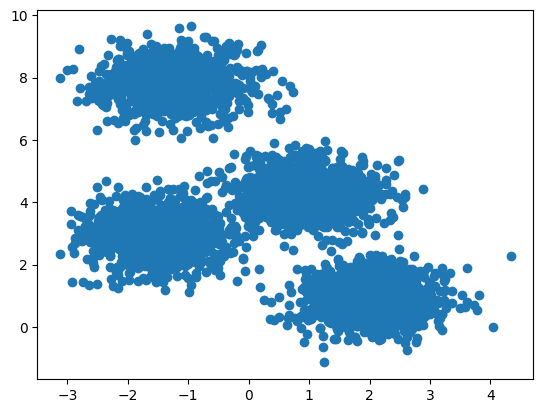

In [173]:
# generate some data
X, y_true = make_blobs(n_samples=4000, centers=4, cluster_std=0.60, random_state=0)

plt.figure()
plt.scatter(X[:,0], X[:,1])
plt.show()
plt.close()

In [174]:
gmm = GaussianMixture(n_components=4)
gmm.fit(X)

GaussianMixture(n_components=4)

In [175]:
gmm.means_

array([[-1.23824476,  7.81555656],
       [ 2.01630043,  0.90234062],
       [ 0.95919476,  4.29696274],
       [-1.5205758 ,  2.92071074]])

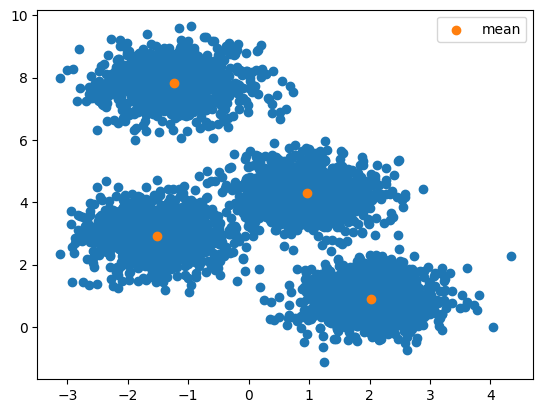

In [176]:
plt.figure()
plt.scatter(X[:,0], X[:,1])
plt.scatter(gmm.means_[:,0], gmm.means_[:,1], label = "mean")
plt.legend()
plt.show()
plt.close()

In [177]:
# weights of each Gaussian i.e p(k)
w_k = gmm.weights_
w_k

array([0.24995563, 0.25010392, 0.24928842, 0.25065202])

In [178]:
# mean of each gaussian
means = gmm.means_
means

array([[-1.23824476,  7.81555656],
       [ 2.01630043,  0.90234062],
       [ 0.95919476,  4.29696274],
       [-1.5205758 ,  2.92071074]])

In [179]:
# mean of each gaussian
cov = gmm.covariances_
cov

array([[[ 0.37956024, -0.00096594],
        [-0.00096594,  0.33053861]],

       [[ 0.3521316 , -0.00251558],
        [-0.00251558,  0.34816653]],

       [[ 0.34150938, -0.00421972],
        [-0.00421972,  0.34663498]],

       [[ 0.35307953, -0.00442887],
        [-0.00442887,  0.36458914]]])

In [180]:
# the probability of p(k | x)
predicted = gmm.predict_proba(X)

In [181]:
predicted, len(predicted)

(array([[4.61018929e-19, 7.08701722e-10, 1.59444189e-06, 9.99998405e-01],
        [1.00000000e+00, 4.57355882e-38, 7.58871885e-13, 1.19436256e-12],
        [2.16336398e-21, 2.41914213e-04, 5.34487544e-04, 9.99223598e-01],
        ...,
        [1.04008839e-46, 1.00000000e+00, 1.48901568e-12, 2.67613974e-13],
        [7.44482445e-20, 6.96553464e-08, 1.39815406e-05, 9.99985949e-01],
        [3.37134949e-38, 9.99999967e-01, 3.25121456e-08, 2.17668488e-14]]),
 4000)

## Plot the data and assign a color to each cluster

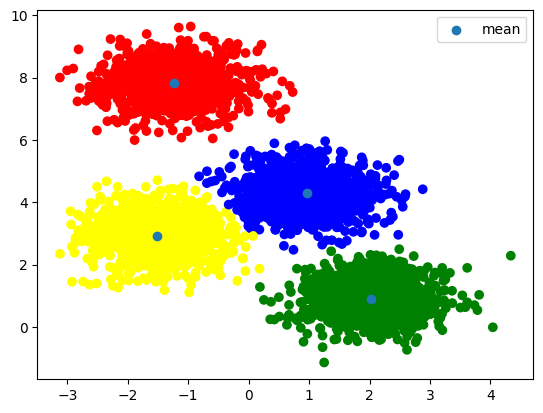

In [182]:
colors = ["red", "green", "blue", "yellow"]
predicted_color = [colors[np.argmax(predicted[i])] for i in range(len(predicted))]
plt.figure()
plt.scatter(X[:,0], X[:,1], c = predicted_color)
plt.scatter(gmm.means_[:,0], gmm.means_[:,1], label = "mean")
plt.legend()

## Verify our Gaussian Naive Bayes Classifier implementation

In [183]:
model = GaussianNaiveBayesClassifier()
model.fit(X, y_true)
model.means, model.cov

(array([[ 0.9584889 ,  4.29462488],
        [ 2.01597244,  0.90074937],
        [-1.52540146,  2.91923688],
        [-1.23802329,  7.81533456]]),
 array([[[ 0.34000474, -0.00413719],
         [-0.00413719,  0.34669759]],
 
        [[ 0.35457285, -0.00128641],
         [-0.00128641,  0.34546413]],
 
        [[ 0.34629331, -0.00773429],
         [-0.00773429,  0.36233373]],
 
        [[ 0.38020996, -0.00120941],
         [-0.00120941,  0.33109048]]]))

In [184]:
predicted = model.predict(X)
predicted

array([2, 3, 2, ..., 1, 2, 1])

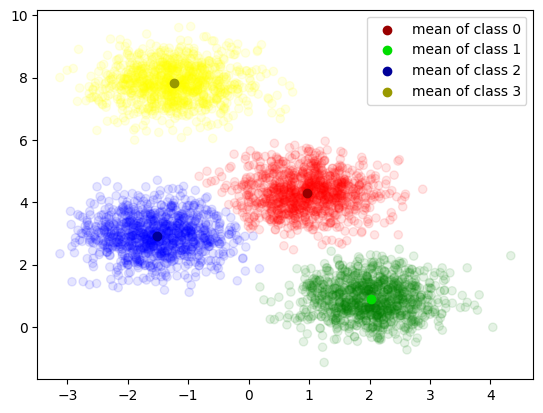

In [185]:
model.plot(X, predicted, colors=["red", "green", "blue", "yellow"], means_colors=["#990000", "#00DD00", "#000099", "#999900"])

In [186]:
model.score(X, y_true)

0.99775

## Verify our Gaussian Naive Bayes Classifier implementation

In [187]:
model = GaussianMixtureNaiveBayesClassifier()
model.fit(X, y_true)
predicted = model.predict(X)
predicted

array([2, 3, 2, ..., 1, 2, 1])

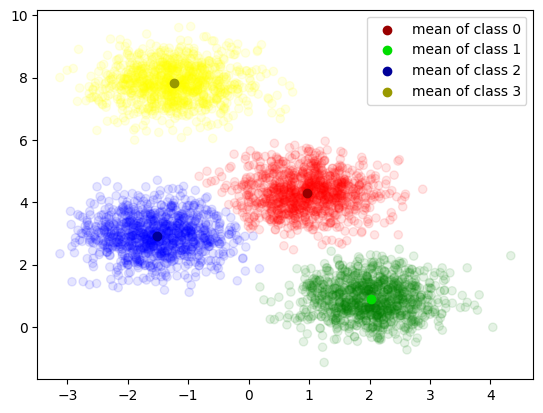

In [188]:
model.plot(X, predicted, colors=["red", "green", "blue", "yellow"], means_colors=["#990000", "#00DD00", "#000099", "#999900"])

In [189]:
model.score(X, y_true)

0.99775

# Probability Density Function of Gaussian Mixture Model

$$f_{GMM}(x_{1},\ldots ,x_{k})= \sum_{i=1}^{k} w_k f_{\mathbf {X} }(x_{1},\ldots ,x_{k};  \mu_i,\Sigma_i),s.t  \sum_{i=1}^{k} w_k  = 1$$

In [190]:
# pdf of gmm
x = (0, 0)

def pdf_mixture(x, w, means, cov):
    n_componets = len(means)
    p_x = 0
    for k in range(n_componets):
        p_x += w[k] * mvn(mean=means[k], cov=cov[k]).pdf(x)
    return p_x

In [191]:
pdf_mixture(x, w_k,  means, cov)

0.00010584089218250922

In [192]:
# notes 1.  if we use covariance_type="diag" the covariance metrix is diagonal

In [193]:
gmm = GaussianMixture(n_components=4, random_state=0, covariance_type="diag")
gmm.fit(X)

GaussianMixture(covariance_type='diag', n_components=4, random_state=0)

In [194]:
# so the cov in a list with the components of the diagonal
gmm.covariances_

array([[0.35306517, 0.36506761],
       [0.37956783, 0.33056489],
       [0.35218237, 0.34835942],
       [0.34120551, 0.34680435]])

In [195]:
# the covariance in case of full matrix
cov

array([[[ 0.37956024, -0.00096594],
        [-0.00096594,  0.33053861]],

       [[ 0.3521316 , -0.00251558],
        [-0.00251558,  0.34816653]],

       [[ 0.34150938, -0.00421972],
        [-0.00421972,  0.34663498]],

       [[ 0.35307953, -0.00442887],
        [-0.00442887,  0.36458914]]])

# Second dataset

In [196]:
# let's generate some data to use to train our models
centers = [(-10,5), (0,0),(0,10), (-7,10)]
X_y_0, _ = make_blobs(n_samples=4000, centers=centers, cluster_std=1.00, random_state=0)
centers = [(-5,5), (-5,-2)]
X_y_1, _ = make_blobs(n_samples=2000, centers=centers, cluster_std=1.00, random_state=0)
X = np.concatenate([X_y_0, X_y_1],axis=0)
Y = np.concatenate([[0]*4000, [1]*2000],axis=0)

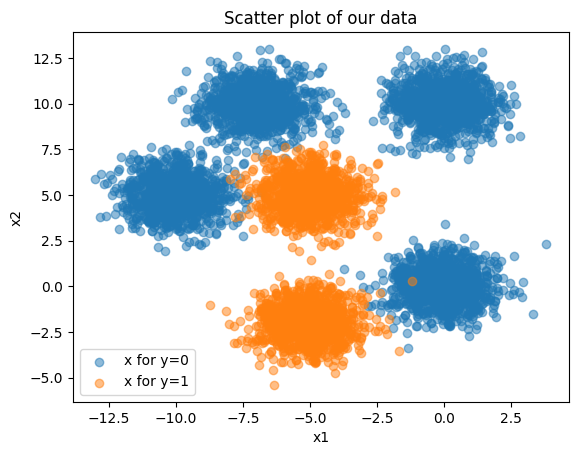

In [197]:
# plt.scatter(X[:,0], X[:,1], color =["r" if y == 1 else "g" for y in Y], alpha = 0.5)
plt.figure()
plt.title("Scatter plot of our data")
plt.scatter(X_y_0[:,0], X_y_0[:,1], alpha = 0.5, label = "x for y=0")
plt.scatter(X_y_1[:,0], X_y_1[:,1], alpha = 0.5, label = "x for y=1")
plt.xlabel("x1")
plt.ylabel("x2")
plt.legend()
plt.show()

## Using GaussianNaiveBayesClassifier

In [198]:
model = GaussianNaiveBayesClassifier()
model.fit(X, Y)
model.means, model.cov

(array([[-4.26716243,  6.24015036],
        [-5.04437158,  1.49346611]]),
 array([[[20.07027141, -3.27336902],
         [-3.27336902, 18.12053493]],
 
        [[ 0.96731886,  0.07185011],
         [ 0.07185011, 13.19366443]]]))

In [199]:
predicted = model.predict(X)
predicted

array([0, 0, 0, ..., 1, 0, 1])

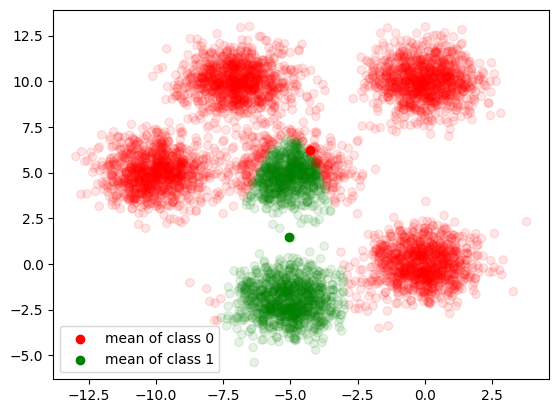

In [200]:
model.plot(X, predicted)

## Using GaussianMixtureNaiveBayesClassifier

In [201]:
model = GaussianMixtureNaiveBayesClassifier()
model.fit(X, Y)
model.means, model.cov

(array([[-4.26716243,  6.24015036],
        [-5.04437158,  1.49346611]]),
 None)

In [202]:
predicted = model.predict(X)
predicted

array([0, 0, 0, ..., 1, 0, 1])

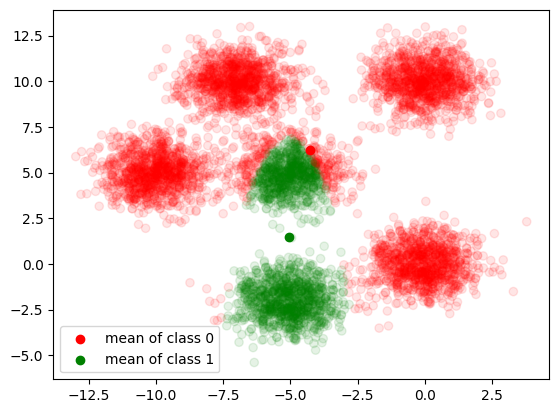

In [203]:
model.plot(X, predicted)

## Using sklearn for Naive Bayes Classifier

In [204]:
from sklearn.naive_bayes import GaussianNB

In [205]:
gmm = GaussianNB()
gmm.fit(X, Y)

GaussianNB()

In [206]:
gmm.theta_, gmm.var_

(array([[-4.26716243,  6.24015036],
        [-5.04437158,  1.49346611]]),
 array([[20.06525386, 18.11600482],
        [ 0.96683522, 13.18706761]]))

In [207]:
predicted = gmm.predict(X)
predicted

array([0, 0, 0, ..., 1, 0, 1])

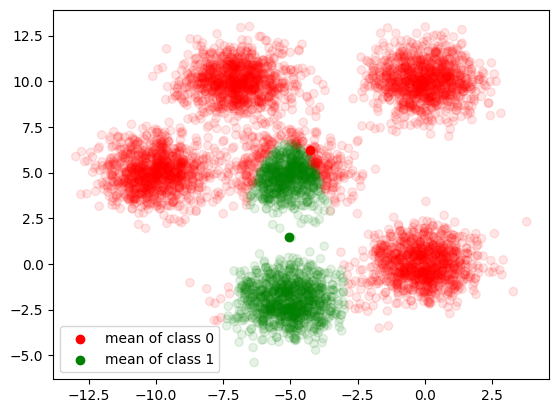

In [208]:
colors = ["red", "green"]
predicted_color = [colors[predicted[i]] for i in range(len(predicted))]
plt.figure()
plt.scatter(X[:,0], X[:,1], c=predicted_color, alpha=0.1)
for i in range(len(gmm.theta_)):
    plt.scatter(gmm.theta_[i,0], gmm.theta_[i,1], label=f"mean of class {i}", color=colors[i])
plt.legend()